In [1]:
%load_ext autoreload
%autoreload 2

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
from darts.utils import statistics
from darts.utils.data import tabularization as tab


import utils


df = utils.load_data()

/Users/Xavier/cdpq-ia/utils.py:224: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  autres = autres.apply(pd.to_numeric, errors="ignore")


# Plot raw values

In [2]:
def do_plot(col, should_diff=False, diff_order=1):
    if should_diff:
        df[col].diff(diff_order).plot(title=col)
    else:
        df[col].plot(title=col)

    plt.show()


interact(
    do_plot,
    col=widgets.Dropdown(options=df.columns, value="US_TB_YIELD_10YRS"),
    should_diff=False,
    diff_order=(1, 12, 1)
)

interactive(children=(Dropdown(description='col', index=3, options=('FFED', 'US_PERSONAL_SPENDING_PCE', 'US_CP…

<function __main__.do_plot(col, should_diff=False, diff_order=1)>

# Preprocess values

Variables that should be differenced are:
- FFED
- US_PERSONAL_SPENDING_PCE
- US_CPI
- US_TB_YIELD_*
- US_UNEMPLOYMENT_RATE (YOY)
- SNP_500 (YOY)

Variables that should not be differenced are:
- NEWS_SENTIMENT


In [3]:
# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(
    covars_diff, should_diff=True, diff_order=1
)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False
)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(
    covars_diff_yoy, should_diff=True, diff_order=12
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)
ts_scaled = ts_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(
    covars_diff_yoy_scaled
)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)

# Reconvert to DataFrame since statsmodels does not support TimeSeries objects
train = train_ts_scaled.pd_dataframe()
validation = val_ts_scaled.pd_dataframe()
history = pd.concat([train, validation])

# Plot processed values

In [4]:
def do_plot(col):
    covariates_scaled[col].plot()
    plt.show()


interact(
    do_plot,
    col=widgets.Dropdown(options=list(covariates_scaled.components), value="US_CPI"),
)

interactive(children=(Dropdown(description='col', index=4, options=('FFED', 'US_TB_YIELD_2YRS', 'US_TB_YIELD_5…

<function __main__.do_plot(col)>

# Variable Selection

In [5]:
ts_lags = list(range(-3, 0))

lags_past_covariates = {
    "US_CPI": list(range(-3, 0)),
    "US_PERSONAL_SPENDING_PCE": list(range(-3, 0)),
    "SNP_500": list(range(-3, 0)),
    "NEWS_SENTIMENT": list(range(-3, 0)),
    "FFED": list(range(-3, 0)),
    "US_UNEMPLOYMENT_RATE": list(range(-3, 0)),
}
covariates_scaled = covariates_scaled[list(lags_past_covariates.keys())]

X_train, y_train, times, last_static_covariates_shape, sample_weight = (
    tab.create_lagged_training_data(
        target_series=train_ts_scaled,
        past_covariates=train_covariates_scaled,
        output_chunk_length=1,
        output_chunk_shift=1,
        lags=ts_lags,
        lags_past_covariates=lags_past_covariates,
        uses_static_covariates=False,
    )
)
X_train = X_train.squeeze()
y_train = y_train.squeeze()


X_test, y_test, times, last_static_covariates_shape, sample_weight = (
    tab.create_lagged_training_data(
        target_series=val_ts_scaled,
        past_covariates=val_covariates_scaled,
        output_chunk_length=1,
        output_chunk_shift=1,
        lags=ts_lags,
        lags_past_covariates=lags_past_covariates,
        uses_static_covariates=False,
    )
)
X_test = X_test.squeeze()
y_test = y_test.squeeze()


features_cols_names, label_cols_names = tab.create_lagged_component_names(
    ts_scaled,
    covariates_scaled,
    lags=ts_lags,
    lags_past_covariates=lags_past_covariates,
    concatenate=False,
)

X_train = pd.DataFrame(X_train, columns=features_cols_names)
y_train = pd.DataFrame(y_train, columns=label_cols_names)

X_test = pd.DataFrame(X_test, columns=features_cols_names)
y_test = pd.DataFrame(y_test, columns=label_cols_names)

In [6]:
X_test.head()

,US_TB_YIELD_10YRS_target_lag-3,US_TB_YIELD_10YRS_target_lag-2,US_TB_YIELD_10YRS_target_lag-1,US_CPI_pastcov_lag-3,US_UNEMPLOYMENT_RATE_pastcov_lag-3,US_PERSONAL_SPENDING_PCE_pastcov_lag-3,SNP_500_pastcov_lag-3,NEWS_SENTIMENT_pastcov_lag-3,FFED_pastcov_lag-3,US_CPI_pastcov_lag-2,...,SNP_500_pastcov_lag-2,US_UNEMPLOYMENT_RATE_pastcov_lag-2,NEWS_SENTIMENT_pastcov_lag-2,FFED_pastcov_lag-2,FFED_pastcov_lag-1,SNP_500_pastcov_lag-1,US_PERSONAL_SPENDING_PCE_pastcov_lag-1,US_CPI_pastcov_lag-1,NEWS_SENTIMENT_pastcov_lag-1,US_UNEMPLOYMENT_RATE_pastcov_lag-1
0,-0.474715,-0.960974,0.400932,0.281083,-0.046336,-0.178089,-0.487953,-0.343249,-0.388900,0.052460,...,-0.825657,-0.018943,-0.618670,-0.720389,-1.236988,0.483041,0.388525,0.005644,0.410846,-0.067472
1,-0.960974,0.400932,-0.233351,0.052460,-0.018943,-0.386630,-0.825657,-0.618670,-0.720389,0.005644,...,0.483041,-0.067472,0.410846,-1.236988,-1.264440,-0.306609,-0.237715,0.041721,-0.287537,0.374338
2,0.400932,-0.233351,0.044717,0.005644,-0.067472,0.388525,0.483041,0.410846,-1.236988,0.041721,...,-0.306609,0.374338,-0.287537,-1.264440,-0.531844,0.158931,0.153047,0.029789,0.174708,-0.410660
3,-0.233351,0.044717,-0.489915,0.041721,0.374338,-0.237715,-0.306609,-0.287537,-1.264440,0.029789,...,0.158931,-0.410660,0.174708,-0.531844,0.775964,-0.353975,-0.182055,0.051042,-0.265726,0.383139
4,0.044717,-0.489915,-0.417751,0.029789,-0.410660,0.153047,0.158931,0.174708,-0.531844,0.051042,...,-0.353975,0.383139,-0.265726,0.775964,0.597755,-0.239914,-0.116601,0.066458,-0.144125,0.114115


# Correlation

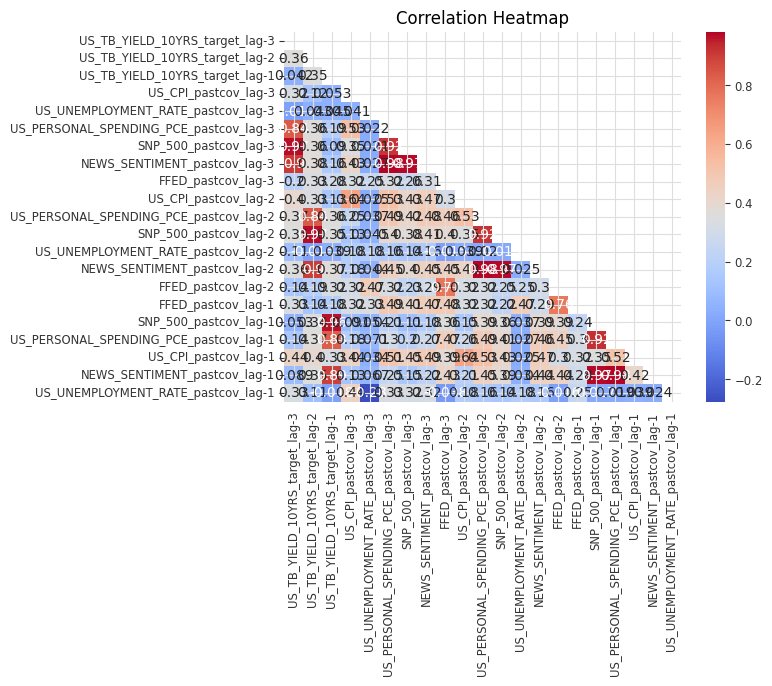

In [7]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(X_test.corr(), dtype=bool))

# Plot the heatmap with the mask
sns.heatmap(X_test.corr(), mask=mask, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Granger Causality

<Axes: xlabel='DATE'>

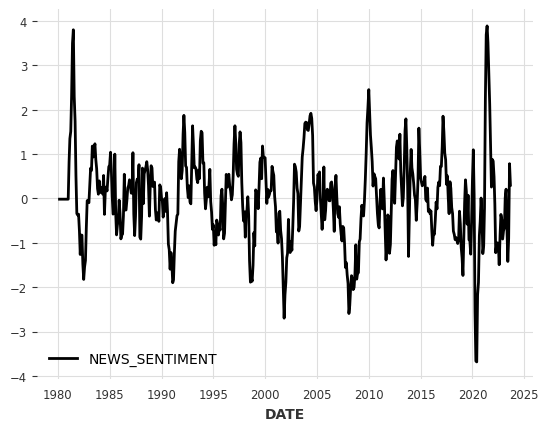

In [8]:
sent = TimeSeries.from_dataframe(df, value_cols=["NEWS_SENTIMENT"])
sent_pipeline, sent_scaled = utils.scale_ts(sent, should_diff=True)
sent_scaled.plot()

In [9]:
# Null hypothesis: the time series is non-stationary
utils.adf_test(sent_scaled.pd_series())

AttributeError: module 'utils' has no attribute 'adf_test'

In [9]:
# Null hypothesis: the time series is stationary
utils.kpss_test(sent_scaled.pd_series())

Results of KPSS Test:


/Users/Xavier/cdpq-ia/utils/utils.py:413: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Test Statistic            0.023708
p-value                   0.100000
Lags Used                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [10]:
results = statistics.granger_causality_tests(ts_scaled, ts_scaled, maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=520, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=55.0121 , p=0.0000  , df_denom=520, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=518, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=39.7895 , p=0.0000  , df_denom=518, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=516, df_num=3
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=25.7618 , p=0.0000  , df_denom=516, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.0000  

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/darts/utils/statistics.py:462: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/darts/utils/statistics.py:462: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


In [11]:
utils.load_data_dict()

,FEATURE_NAME,FEATURE_CATEGORY,FEATURE_DESCRIPTION
0,US_CPI,INFLATION,"Consumer Price Index for the United States, me..."
1,US_CPI_EXCL_FOOD_N_ENERGY,INFLATION,Consumer Price Index for the United States exc...
2,US_PERSONAL_SPENDING_PCE,INFLATION,"Personal Consumption Expenditures Price Index,..."
3,CANADA_CPI,INFLATION,"Consumer Price Index for Canada, measuring the..."
4,CANADA_CPI_EXCL_FOOD_N_ENERGY,INFLATION,Consumer Price Index for Canada excluding food...
5,US_CAPACITY_UTILIZATION,GDP_ECONOMIC_GROWTH,Percentage of resources used by corporations a...
6,US_M2,GDP_ECONOMIC_GROWTH,Measure of the money supply that includes cash...
7,US_CONSUMER_CREDIT,GDP_ECONOMIC_GROWTH,Total amount of credit extended to individuals...
8,US_INDUSTRIAL_PRODUCTION,GDP_ECONOMIC_GROWTH,Measure of the output of the industrial sector...
9,US_NFP_ESTABLISHMENT_DATA,GDP_ECONOMIC_GROWTH,"Nonfarm Payrolls data, representing the total ..."
